# Class 4 - Bias-variance trade-off and Decision Trees
Yesterday, we introduce the notions of bias and variance, which quantify two dimensions of error in predictive modeling. We saw that:
- *Bias* is the distance between the average of predictions made by a given model when trained on different training sets and the predictions made by the true model;
- *Variance* is the variance of predictions made by a given model when trained on different training sets.

Importantly, bias and variance are modulated by the complexity or flexibility of a model in different ways. As complexity/flexibility increases, bias tends to decrease, while variance increases.

This is why we talk about a _bias-variance trade-off_: ideally, we want to minimize both sources of prediction error, but in practice, modeling decisions that lead to lower bias will also lead to higher variance (and viceversa).
What we want to do when designing our model is to hit the optimal balance between bias and variance.

Alongside this, we introduced **decision trees** as an additional modeling algorithm for both regression and classification.
Decision trees are implemented in `scikit-learn`. You can check out this link for a brush-up of what they are with some examples: https://scikit-learn.org/stable/modules/tree.html. 
Classes for regression (`DecisionTreeRegressor`) and classification (`DecisionTreeClassifier`) are documented respectively at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html and https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html. 
We have discussed hyperparameters of decision trees that influence its complexity and flexibility (e.g., tree depth, minimum number of total samples per leaf), and discussed why flexibility matters for learning good decision trees.

In this exercise, we will take a break from our attempt to model bike data (fear not, we will resume next week and combine all we have learned so far with tree-based bagging and boosting methods, which we will introduce next week).
Our goal for today is see some of the notions we have introduced theoretically during our lecture in action, to get a better grasp of these complex notions.
We will look at a practical example of how bias and variance are modulated by model flexibility, using a linear model and decision trees as a test case.

### Today's plan
**Step 1** - Generating Data:
1. Generate 1000 data points from a uniform distribution, using `numpy.random.uniform` (https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html). Set the minimum value to -10 and the maximum value to 10. This will be your $x$.
2. Generate polynomial terms for x, using `sklearn.preprocessing.PolynomialFeatures` (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
3. Generate 4 random coefficients $\beta_{i}$ from a uniform distribution (same parameters as above)
4. Generate an outcome variable using the following equation: $y = \beta_{0} + \beta_{1} * x + \beta_{2} * x^2 + \beta_{3} * x^3 $. To do so, you might find 
5. Add some Gaussian noise to your $y$ using `np.random.normal` (set the `scale` parameter to 10 to make this noise "visible", see https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)
6. Plot the relation between $x$ and $y$
7. Finally, split your data into two halves, a training and a test set, using sklearn's `train_test_split`

**Step 2** - Compute squared bias and variance of linear models with increasing complexity:
1. Compute average **squared bias**, **variance**, and **MSE** for a linear model that only uses *x* as input feature.
    - To do so, you need to create a loop where you take random samples of the training data (1/2 the size of the training set), say, 100 times. This process is called **bootstrapping**.
    - For each random split of the data:
        - You fit a `LinearRegression` estimator on the sampled data
        - You predict $\hat{y}$ for all test data points
        - You compute the average **squared** bias across all data points in the test set. To do so you need to:
            1. Compute the average prediction of your bootstrapped models for each data point
            2. Compute the difference between these values and the predictions of the true model for each data point
            3. Take the squared value of that
            4. Average across all data points
            5. NOTE: we look at the average *squared* bias, because the bias of a single data point encodes information about the *directionality* of the error. If we averaged those values, we will underestimate models' tendency to make systematic errors.
        - You compute the average variance of the predictions of bootstrapped models across all data points in the test set
        - You compute the average MSE of your method (computing the average of MSEs of each bootstrapped model)
2. Now that you know how to compute this, scale this up. Fit linear regressions with input features that include increasingly high polynomial expansions of your feature set (first only $x, x^2$, then $x, x^2, x^3$ and all the way up to $x,...,x^{10}$)
3. Make a plot where you show how bias, variance and MSE change as a function of model complexity (i.e., how many polynomials you include)
4. Look at the patterns emerging from the plot and discuss them with your group: what do you notice?

**Bonus tasks**:
- We have talked about decision trees in the lecture. Can you do minimal changes to the code above, to look at how bias and variance change as a function of the expected depth of a tree, or additional parameters related to the complexity of a decision tree? Use `DecisionTreeRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) as an extractor, and loop over multiple values of `max_depth` (e.g., ranging from 1 to 20)
- How do your results change as you manipulate parameters such as the the true generative model (e.g., its complexity), the size of bootstrapped data samples, etc?


### Solutions
As usual, you will find a solution in `example.ipynb`

In [53]:
%pip install scikit-learn pandas numpy matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Step 1: Generating Data

In [55]:
np.random.seed(2802)
x_raw = np.random.uniform(low = -10, high= 10, size=(1000, 1))

In [71]:
degree=3
poly = PolynomialFeatures(degree=degree)
X = poly.fit_transform(x_raw)

In [57]:
X

array([[ 1.00000000e+00,  6.63867006e+00,  4.40719401e+01, ...,
         3.77266877e+06,  2.50455032e+07,  1.66268832e+08],
       [ 1.00000000e+00,  6.22773703e+00,  3.87847085e+01, ...,
         2.26277894e+06,  1.40919922e+07,  8.77612216e+07],
       [ 1.00000000e+00,  3.53840263e+00,  1.25202931e+01, ...,
         2.45729892e+04,  8.69491294e+04,  3.07661028e+05],
       ...,
       [ 1.00000000e+00,  8.71611642e+00,  7.59706855e+01, ...,
         3.33107323e+07,  2.90340221e+08,  2.53063917e+09],
       [ 1.00000000e+00, -2.92365106e+00,  8.54773554e+00, ...,
         5.33831637e+03, -1.56073743e+04,  4.56305166e+04],
       [ 1.00000000e+00, -8.98150882e+00,  8.06675007e+01, ...,
         4.23442462e+07, -3.80315221e+08,  3.41580451e+09]])

In [58]:
np.random.seed(2802)
betas = np.random.uniform(low = -10, high = 10, size=(len(X[1]), ))

In [59]:
y_raw = np.dot(X, betas)
print(y_raw.shape)
print(y_raw[1:10])

(1000,)
[3.56093886e+08 1.46953144e+06 3.42955268e+02 8.02497072e+09
 1.07994247e+09 5.73045974e+00 1.37332570e+10 2.41978387e+06
 2.36703993e+10]


In [60]:
# define noise
np.random.seed(2802)
noise = np.random.normal(loc=0.0, scale=10, size=len(y_raw))

In [61]:
# add noise to y
y = y_raw + noise
print(y[1:10])

[3.56093890e+08 1.46953941e+06 3.60712867e+02 8.02497071e+09
 1.07994247e+09 1.99284773e+00 1.37332570e+10 2.41978308e+06
 2.36703993e+10]


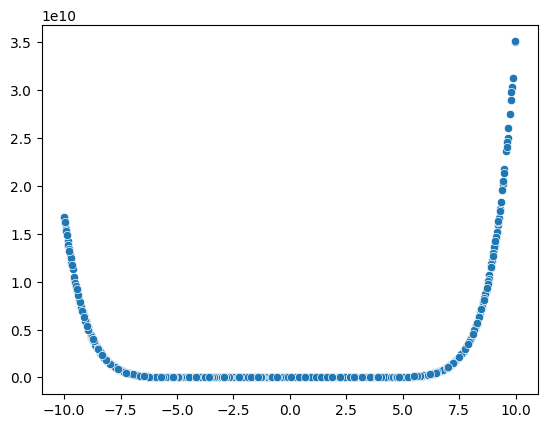

In [62]:
# plot relation to x 
sns.scatterplot(x=x_raw[:,0], y=y)
plt.show()

In [63]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.5, random_state=2802)

# get true predictions
y_pred_true = np.dot(X_test, betas)

## Step 2: Computing Squared Bias, Variance, MSE

In [64]:
def bootstrap(X_train, y_train, X_test, y_test, y_pred_true, n_iterations=100, degree=1, model=LinearRegression()): 
    '''run bootstrapping for n iterations'''
    # all preds 
    y_preds = []
    
    # select degree of polynomial
    X_train = X_train[:, 0:degree+1]
    X_test = X_test[:, 0:degree+1]
    
    # define split size 
    split_size = 0.5

    for i in range(n_iterations): 
        # create random subset 
        X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=split_size)

        # fit model
        model.fit(X_train_subset, y_train_subset)

        # get predictions, add to list
        y_pred = model.predict(X_test)
        y_preds.append(y_pred.reshape(-1, 1))

    # convert predictons to proper array
    y_preds = np.hstack(y_preds)

    # compute average prediction
    average_y_preds = np.mean(y_preds, axis=1)

    # compute diff 
    y_preds_diff = y_pred_true - average_y_preds 

    # take squared diff 
    y_preds_diff_squared = np.square(y_preds_diff)

    # compute bias
    average_squared_bias = np.mean(y_preds_diff_squared)

    # compute variance
    average_variance = y_preds.var(axis=1).mean()

    # compute 
    average_mse = np.mean([np.sqrt(mean_squared_error(y_test, y_preds[:,i])) for i in range(n_iterations)])

    results = {
        "degree":degree, 
        "average_squared_bias": average_squared_bias,
        "average_variance": average_variance, 
        "average_mse": average_mse, 
    }
    
    return results

In [65]:
# test function for one specified degree
results = bootstrap( 
                        X_train = X_train, 
                        y_train = y_train, 
                        X_test = X_test, 
                        y_test = y_test, 
                        y_pred_true = y_pred_true, 
                        n_iterations = 100, 
                        degree = 2,
                        model = LinearRegression()
                                                    )  

In [66]:
results

{'degree': 2,
 'average_squared_bias': 9.961014854286264e+18,
 'average_variance': 1.485652080413e+17,
 'average_mse': 3179306352.785806}

In [67]:
def bootstrap_models(X_train, y_train, X_test, y_test, y_pred_true, n_iterations_per_degree=100, total_degrees=1, model=LinearRegression()):
    '''bootstrap several mdls'''
    all_results = []

    for degree in range(total_degrees+1): 
        results = bootstrap(
                    X_train = X_train,
                    y_train = y_train, 
                    X_test = X_test, 
                    y_test = y_test, 
                    y_pred_true = y_pred_true,  
                    n_iterations = 100, 
                    degree = degree,
                    model = LinearRegression())  
    
        all_results.append(results)

    all_results_df = pd.DataFrame(all_results)
    
    # Scale bias, variance, and MSE
    scaler = MinMaxScaler()
    for metric in ["average_squared_bias", "average_variance", "average_mse"]:
        all_results_df[f"scaled_{metric.split('_')[-1]}"] = scaler.fit_transform(all_results_df[metric].values.reshape(-1, 1))

    return all_results_df

In [68]:
# test function for all degrees
data = bootstrap_models( 
                        X_train = X_train, 
                        y_train = y_train, 
                        X_test = X_test, 
                        y_test = y_test, 
                        y_pred_true = y_pred_true, 
                        n_iterations_per_degree = 100, 
                        total_degrees = 3,
                        model = LinearRegression()
                                                    )  

In [69]:
data

,degree,average_squared_bias,average_variance,average_mse,scaled_bias,scaled_variance,scaled_mse
0,0,2.469741e+19,3.729363e+16,4.973397e+09,1.000000,0.000000,1.000000
1,1,2.340453e+19,1.740878e+17,4.855593e+09,0.918669,0.807085,0.940281
2,2,9.965504e+18,1.396981e+17,3.178611e+09,0.073267,0.604185,0.090150
3,3,8.800816e+18,2.067854e+17,3.000780e+09,0.000000,1.000000,0.000000


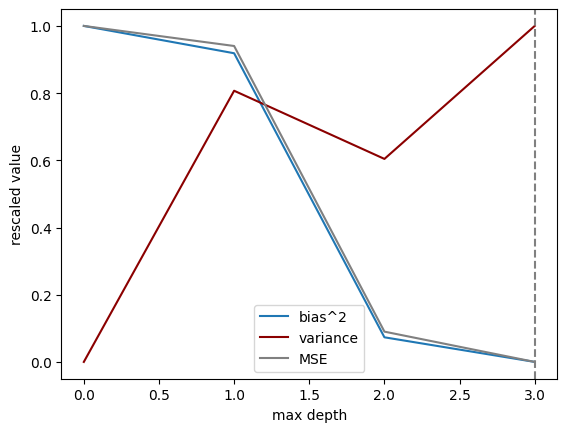

In [70]:
sns.lineplot(data=data, x='degree', y='scaled_bias', label='bias^2')
sns.lineplot(data=data, x='degree', y='scaled_variance', label='variance', color='darkred')
sns.lineplot(data=data, x='degree', y='scaled_mse', label='MSE', color='grey')
plt.xlabel('max depth')
plt.ylabel('rescaled value')
plt.axvline(x=data.iloc[data['average_mse'].argmin()]['degree'], 
            linestyle='--',
            color='grey')
plt.show()